# Bước 3: Apriori Modeling for Association Rules

Notebook này sử dụng ma trận `basket_bool` (được chuẩn bị ở bước 02) để:

- Khai thác **tập mục phổ biến** (frequent itemsets) bằng thuật toán **Apriori**
- Sinh **luật kết hợp** (association rules) với các chỉ số: `support`, `confidence`, `lift`
- Lọc luật theo các ngưỡng do người dùng cấu hình
- Trực quan hoá một số nhóm luật tiêu biểu phục vụ storytelling & phân tích kinh doanh
- Lưu kết quả luật đã lọc ra file `.csv` để sử dụng trong báo cáo, dashboard hoặc các bước phân tích tiếp theo

Notebook được thiết kế theo kiểu *parameterized* để dễ dàng tích hợp với **papermill**, cho phép chạy tự động với các ngưỡng support/confidence khác nhau mà không cần sửa code.


In [1]:
# PARAMETERS (for papermill)

# Đường dẫn tới basket_bool được tạo từ Notebook 02
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Đường dẫn lưu file luật kết hợp sau khi lọc
RULES_OUTPUT_PATH = "data/processed/rules_apriori_filtered.csv"

# Tham số cho bước khai thác tập mục phổ biến (frequent itemsets)
MIN_SUPPORT = 0.01     # ngưỡng support tối thiểu
MAX_LEN = 3            # độ dài tối đa của itemset (số sản phẩm trong 1 tập)

# Tham số cho bước sinh luật
METRIC = "lift"        # chỉ số dùng để generate rules: 'support' / 'confidence' / 'lift'
MIN_THRESHOLD = 1.0    # ngưỡng tối thiểu cho METRIC

# Tham số lọc luật sau khi generate
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1

# Số lượng luật top để vẽ biểu đồ
TOP_N_RULES = 20

# Bật/tắt các biểu đồ matplotlib
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True

# Bật/tắt biểu đồ HTML tương tác (Plotly)
PLOT_PLOTLY_SCATTER = True


In [2]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
RULES_OUTPUT_PATH = "data/processed/rules_apriori_filtered.csv"
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1
TOP_N_RULES = 20
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True
PLOT_PLOTLY_NETWORK = True
PLOT_PLOTLY_SCATTER = True


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Biểu đồ tương tác HTML
import plotly.express as px

from apriori_library import AssociationRulesMiner, DataVisualizer  # classes trong library của bạn


## Thiết lập style vẽ biểu đồ 

In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


In [5]:
# Khởi tạo DataVisualizer với style đã cấu hình
visualizer = DataVisualizer()

## Tải basket_bool

In [6]:
# Đọc ma trận basket_bool từ bước 2
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")

basket_bool.head()


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Khai thác tập phổ biến bằng thuật toán Apriori

In [7]:
# Khởi tạo Apriori miner
miner = AssociationRulesMiner(basket_bool=basket_bool)

start_time = time.time()
frequent_itemsets_ap = miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    use_colnames=True,
)
elapsed_time = time.time() - start_time

print("=== Kết quả khai thác tập mục phổ biến (Apriori) ===")
print(f"- Thời gian chạy: {elapsed_time:.2f} giây")
print(f"- Số tập mục phổ biến thu được: {len(frequent_itemsets_ap):,}")

frequent_itemsets_ap.head(10)


=== Kết quả khai thác tập mục phổ biến (Apriori) ===
- Thời gian chạy: 14.33 giây
- Số tập mục phổ biến thu được: 2,120


,support,itemsets
782,0.119971,(WHITE HANGING HEART T-LIGHT HOLDER)
357,0.107375,(JUMBO BAG RED RETROSPOT)
563,0.093502,(REGENCY CAKESTAND 3 TIER)
473,0.088397,(PARTY BUNTING)
397,0.077243,(LUNCH BAG RED RETROSPOT)
55,0.076078,(ASSORTED COLOUR BIRD ORNAMENT)
631,0.068864,(SET OF 3 CAKE TINS PANTRY DESIGN )
426,0.067643,(NATURAL SLATE HEART CHALKBOARD )
389,0.067477,(LUNCH BAG BLACK SKULL.)
310,0.064591,(HEART OF WICKER SMALL)


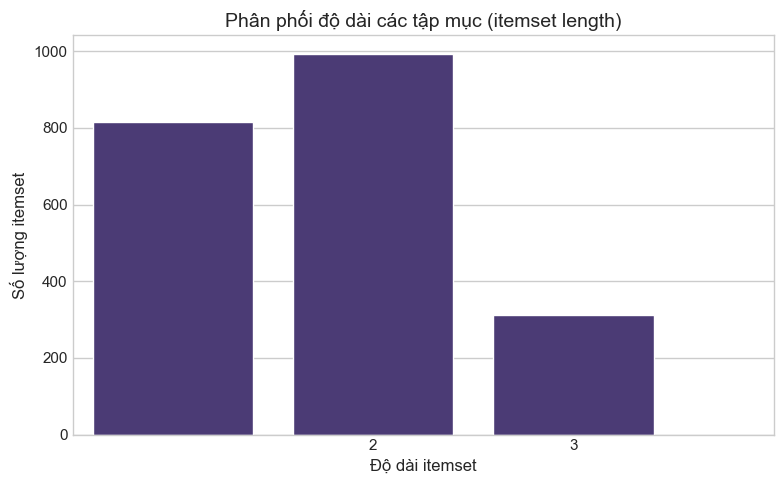

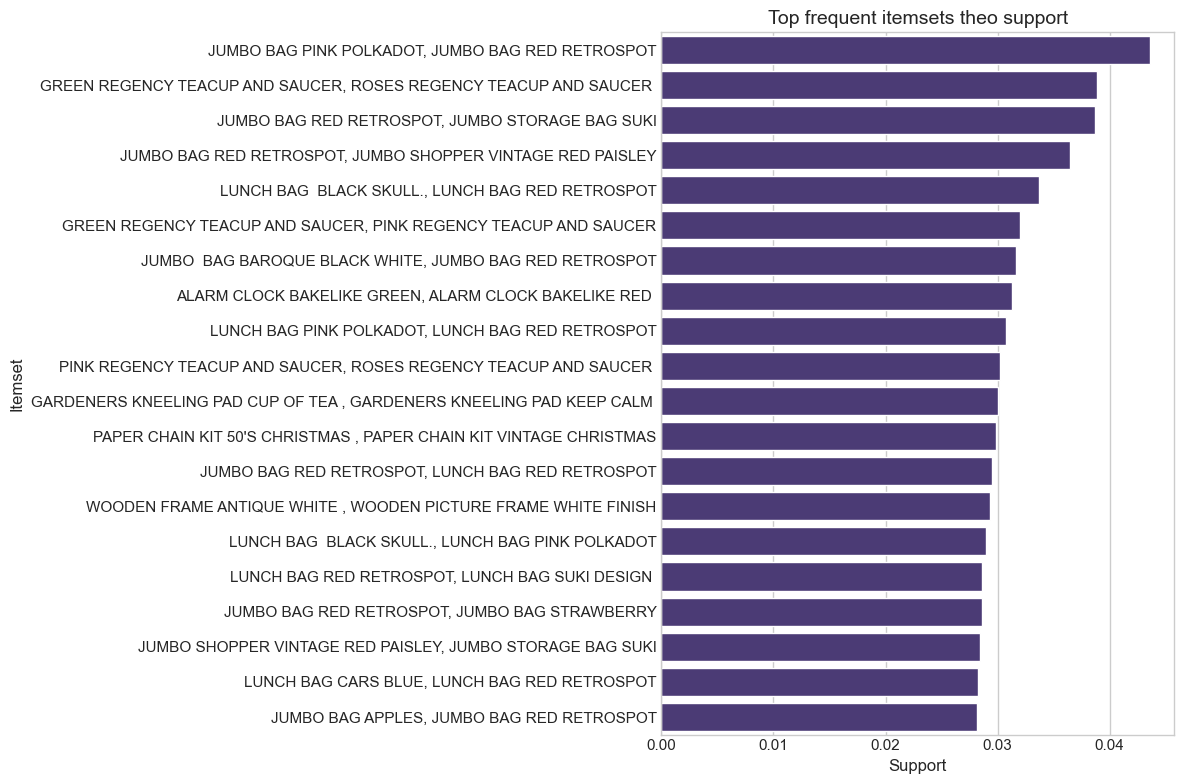

In [8]:
# Trực quan hoá frequent itemsets trước khi sinh luật
if frequent_itemsets_ap is not None and not frequent_itemsets_ap.empty:
    # Phân phối độ dài các tập mục (1-itemset, 2-itemset, 3-itemset, ...)
    visualizer.plot_itemset_length_distribution(
        frequent_itemsets=frequent_itemsets_ap
    )

    # Top các tập mục phổ biến nhất theo support (ưu tiên itemset có từ 2 sản phẩm trở lên)
    visualizer.plot_top_frequent_itemsets(
        frequent_itemsets=frequent_itemsets_ap,
        top_n=20,
        min_len=2
    )
else:
    print("Không có frequent itemsets để trực quan hoá.")


## Sinh luật kết hợp từ tập mục phổ biến

In [9]:
rules_ap = miner.generate_rules(
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

# Thêm cột dạng chuỗi dễ đọc
rules_ap = miner.add_readable_rule_str()

print("=== Một vài luật kết hợp đầu tiên (chưa lọc) ===")
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]
rules_ap[cols_preview].head(10)


=== Một vài luật kết hợp đầu tiên (chưa lọc) ===


,antecedents_str,consequents_str,support,confidence,lift
2640,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
2645,HERB MARKER THYME,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",0.010932,0.856522,74.567045
3005,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
3008,HERB MARKER ROSEMARY,"HERB MARKER MINT, HERB MARKER THYME",0.010599,0.826840,74.502403
3263,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
3266,HERB MARKER PARSLEY,"HERB MARKER MINT, HERB MARKER THYME",0.010432,0.824561,74.297105
2641,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
2644,HERB MARKER ROSEMARY,"HERB MARKER PARSLEY, HERB MARKER THYME",0.010932,0.852814,74.244244
2870,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
2871,HERB MARKER ROSEMARY,"HERB MARKER BASIL, HERB MARKER THYME",0.010710,0.835498,74.169983


## Lọc các luật theo ngưỡng support/ confidence / lift

In [10]:
rules_filtered_ap = miner.filter_rules(
    min_support=FILTER_MIN_SUPPORT,
    min_confidence=FILTER_MIN_CONF,
    min_lift=FILTER_MIN_LIFT,
    max_len_antecedents=FILTER_MAX_ANTECEDENTS,
    max_len_consequents=FILTER_MAX_CONSEQUENTS,
)

print("=== Thống kê sau khi lọc luật ===")
print(f"- Tổng số luật ban đầu: {rules_ap.shape[0]:,}")
print(f"- Số luật sau khi lọc: {rules_filtered_ap.shape[0]:,}")

rules_filtered_ap[cols_preview].head(10)


=== Thống kê sau khi lọc luật ===
- Tổng số luật ban đầu: 3,856
- Số luật sau khi lọc: 1,794


,antecedents_str,consequents_str,support,confidence,lift
0,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010932,0.951691,74.567045
1,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010599,0.955000,74.502403
2,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,0.010432,0.940000,74.297105
3,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010932,0.951691,74.244244
4,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,0.010710,0.950739,74.169983
5,"HERB MARKER BASIL, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010710,0.936893,73.407619
6,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER THYME,0.010599,0.931707,73.001294
7,"HERB MARKER MINT, HERB MARKER ROSEMARY",HERB MARKER PARSLEY,0.010488,0.921951,72.870539
8,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER PARSLEY,0.010377,0.921182,72.809761
9,HERB MARKER CHIVES,HERB MARKER PARSLEY,0.010377,0.921182,72.809761


## Trực quan top các luật theo Lift

In [11]:
visualizer = DataVisualizer()


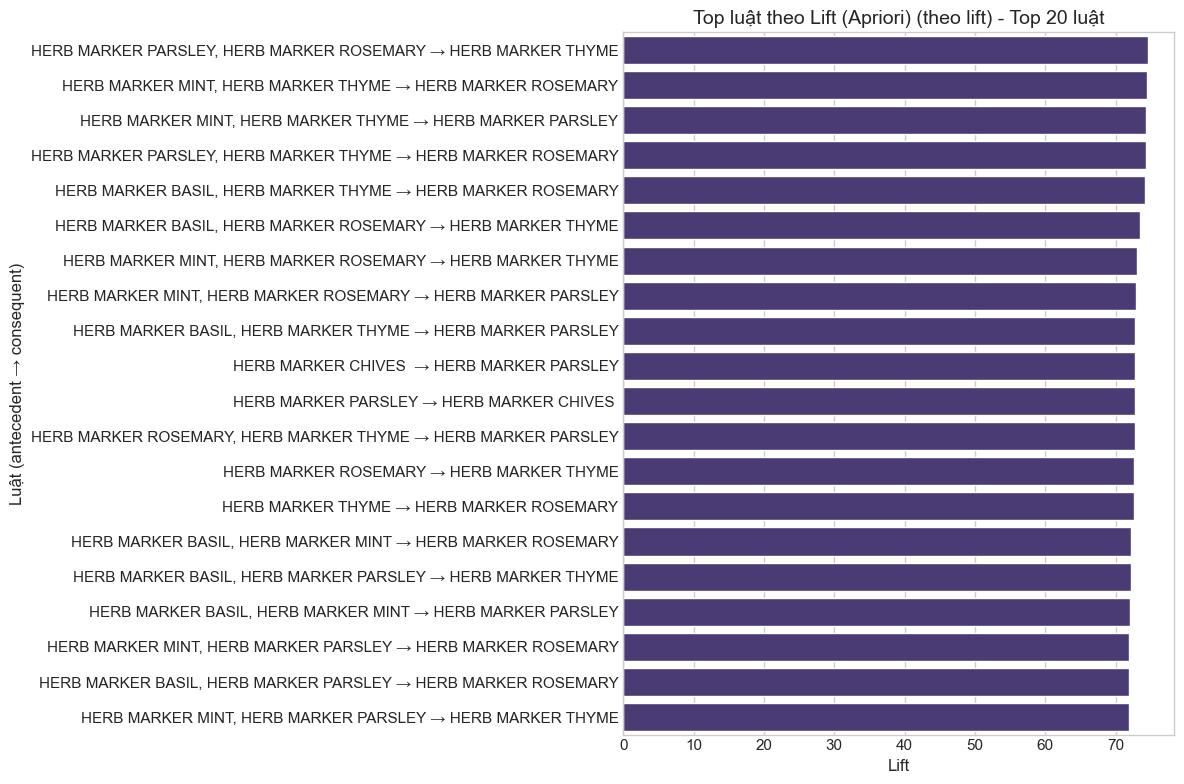

In [12]:
if PLOT_TOP_LIFT and not rules_filtered_ap.empty:
    visualizer.plot_top_rules_lift(
        rules_df=rules_filtered_ap,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ top lift.")
    else:
        print("PLOT_TOP_LIFT = False, bỏ qua biểu đồ top lift.")


## Trực quan top luật theo confidence

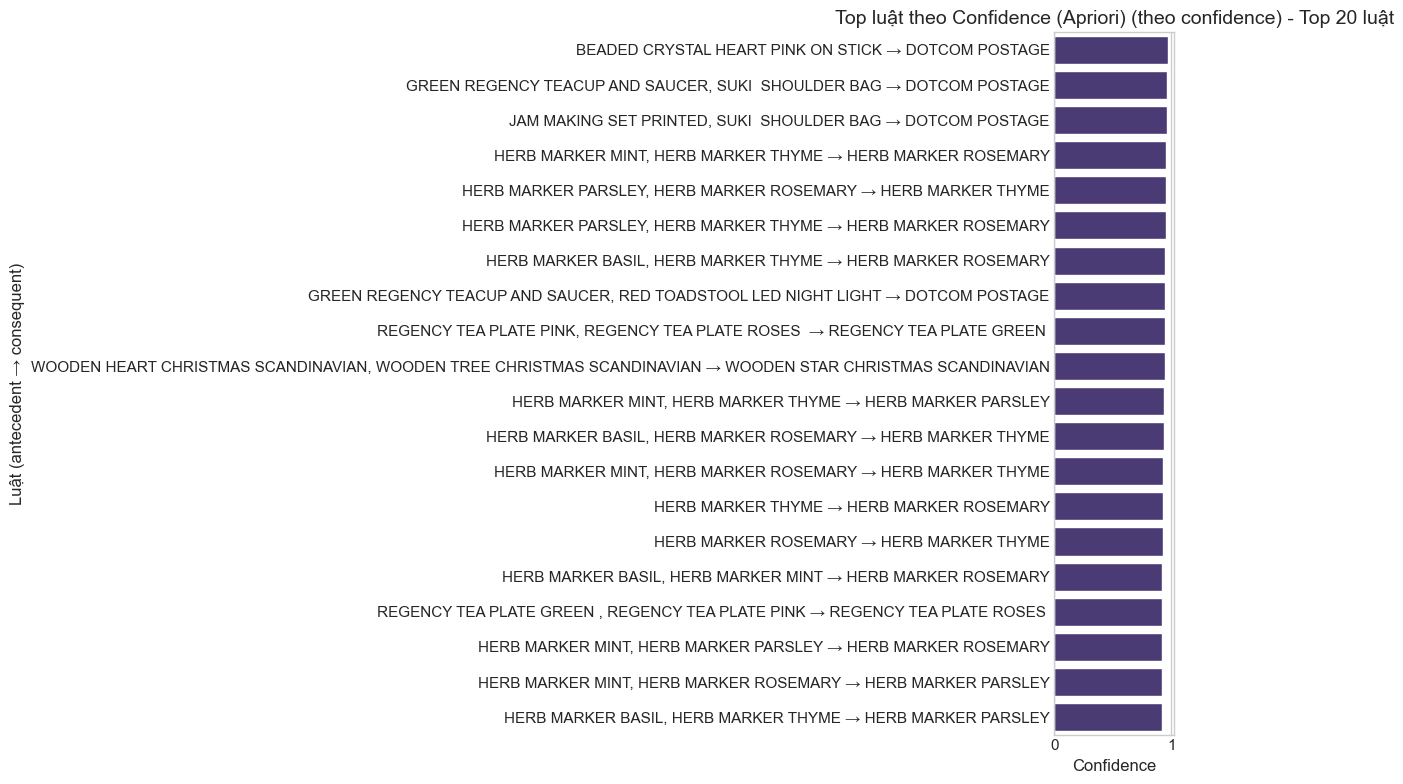

In [13]:
if PLOT_TOP_CONF and not rules_filtered_ap.empty:
    visualizer.plot_top_rules_confidence(
        rules_df=rules_filtered_ap,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ top confidence.")
    else:
        print("PLOT_TOP_CONF = False, bỏ qua biểu đồ top confidence.")


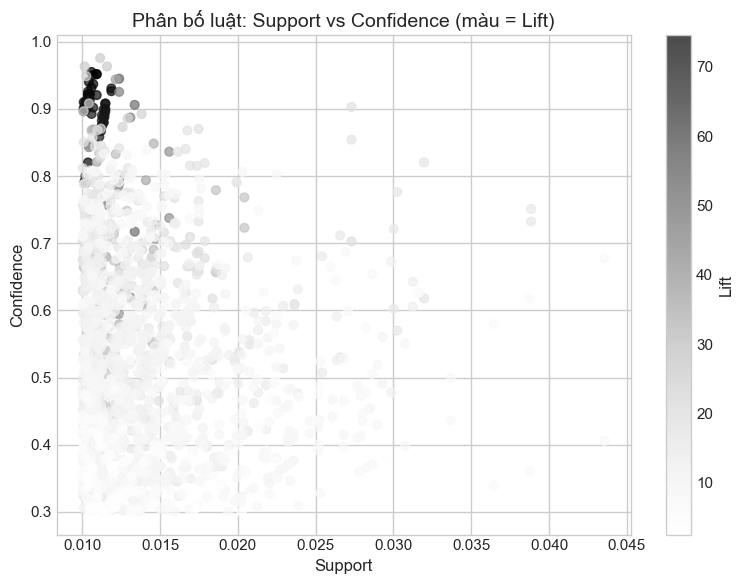

In [14]:
# Trực quan hoá quan hệ support vs confidence
if PLOT_SCATTER and not rules_filtered_ap.empty:
    visualizer.plot_rules_support_confidence_scatter(
        rules_df=rules_filtered_ap,
    )
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter.")
    else:
        print("PLOT_SCATTER = False, bỏ qua biểu đồ scatter.")


In [15]:
## Tạo biểu đồ bằng HTML (Plotly)
if PLOT_PLOTLY_SCATTER and not rules_filtered_ap.empty:
    visualizer.plot_rules_support_confidence_scatter_interactive(
        rules_df=rules_filtered_ap,
    )
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter Plotly.")
    else:
        print("PLOT_PLOTLY_SCATTER = False, bỏ qua biểu đồ Plotly.")


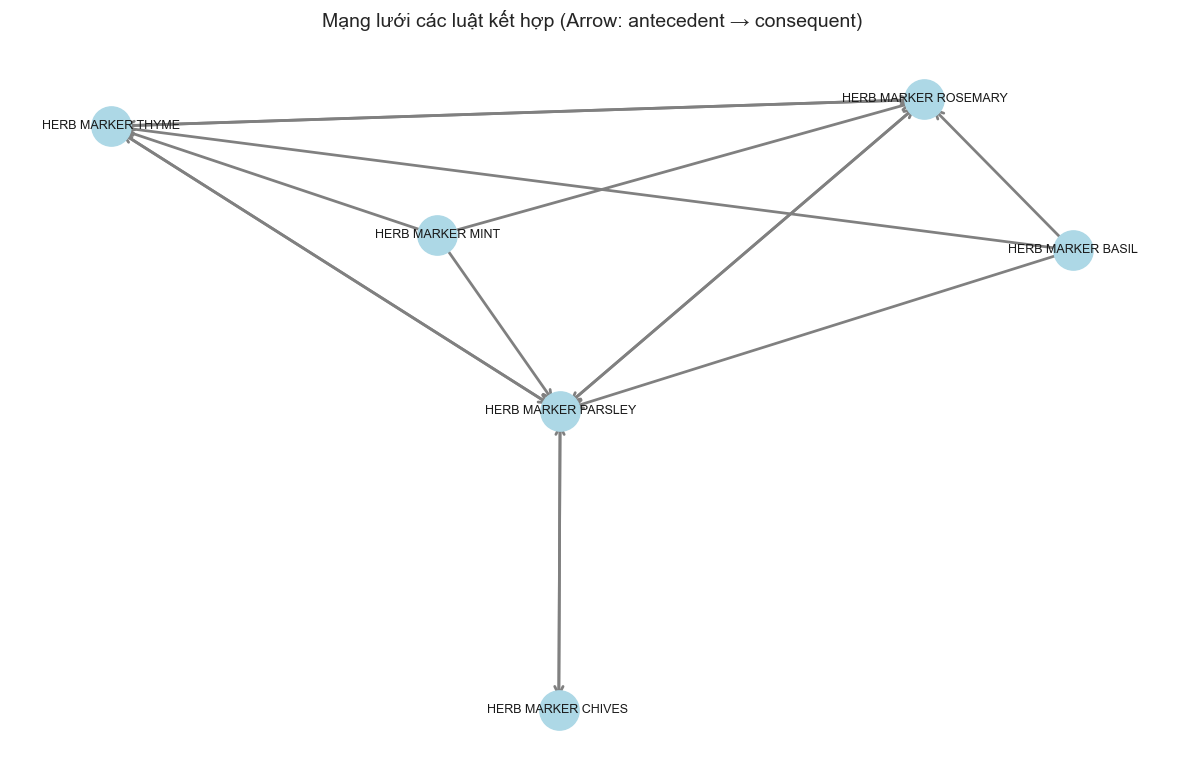

In [16]:
## Network các luật có lift cao
if PLOT_NETWORK and not rules_filtered_ap.empty:
    # Lấy một tập luật nhỏ để vẽ mạng (tránh quá rối)
    visualizer.plot_rules_network(
        rules_df=rules_filtered_ap,
        max_rules=min(TOP_N_RULES, 30),
    )
else:
    if rules_filtered_ap.empty:
        print("Không có luật nào sau khi lọc để vẽ network graph.")
    else:
        print("PLOT_NETWORK = False, bỏ qua network graph.")


In [17]:
## Lưu luật đã lọc ra file CSV

# Lưu luật đã lọc để dùng trong báo cáo / dashboard
miner.save_rules(
    output_path=RULES_OUTPUT_PATH,
    rules_df=rules_filtered_ap,
)

print("Đã lưu luật Apriori đã lọc:")
print(f"- File: {RULES_OUTPUT_PATH}")
print(f"- Số luật: {rules_filtered_ap.shape[0]:,}")


Đã lưu luật vào: data/processed/rules_apriori_filtered.csv
Đã lưu luật Apriori đã lọc:
- File: data/processed/rules_apriori_filtered.csv
- Số luật: 1,794


## Gợi ý cách đọc & sử dụng các luật kết hợp

Một số hướng khai thác luật kết hợp trong bối cảnh kinh doanh:

- Các luật có **lift cao**:
  - Thể hiện những cặp/bộ sản phẩm gắn bó chặt chẽ hơn nhiều so với ngẫu nhiên.
  - Gợi ý cho: combo sản phẩm, trưng bày trên kệ, chương trình mua kèm.

- Các luật có **confidence cao nhưng support vừa phải**:
  - Thích hợp cho chiến dịch cá nhân hoá: 
  - Khi khách đã mua `antecedent`, xác suất mua `consequent` rất cao.

- Luật có **support cao nhưng lift không quá lớn**:
  - Thể hiện các thói quen mua sắm phổ biến.
  - Giúp hiểu "giỏ hàng trung bình" của khách hàng.

Khi kết hợp với RFM ở Notebook 01, ta có thể:
- Áp dụng luật khác nhau cho nhóm khách hàng VIP / mới / có rủi ro rời bỏ.
- Thiết kế chiến dịch gợi ý sản phẩm theo phân khúc khách hàng cụ thể.
